In [1]:
# !pip install cfgrib s3fs h5netcdf h5pyd

In [2]:
import io
from datetime import date, timedelta, datetime

In [3]:
# Constants for creating the full URL
source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
sector = "conus"
start_time = "2022-06-01 00:00"
fmt = "%Y-%m-%d %H:%M"
time1 = datetime.strptime(start_time, fmt)
day_date=time1.strftime("%Y%m%d")
cycle = 12          # hour
forecast_hour = 0   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
grib_url=source_url+"/hrrr."+day_date+"/conus/"+file_path

print(grib_url)

https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220601/conus/hrrr.t12z.wrfsfcf00.grib2


In [4]:
# Setup
import os
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import io
import requests
import s3fs
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

start_time = "2022-06-01 00:00"
end_time = "2022-06-30 00:00"

* https://registry.opendata.aws/noaa-hrrr-pds/

* https://spire.com/tutorial/spire-weather-tutorial-intro-to-processing-grib2-data-with-python/

* https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md

* https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb

* https://github.com/ecmwf/cfgrib/issues/63

* https://github.com/blaylockbk/Herbie/discussions/45

In [5]:
# Read in list of RAWS Stations
df = pd.read_csv("raws_stations_WA.csv")

# Filter to those with complete fmda data
df = df[(df[['air_temp', 'relative_humidity', 'precip_accum',
       'fuel_moisture', 'wind_speed', 'solar_radiation']]==1).sum(axis=1)==6]

# Get list of coords
points = list(df[["lon","lat"]].itertuples(index=False,name=None))
names = np.unique(df['STID'])

print(df.shape)

(40, 9)


In [6]:
from data_funcs import download_grib

Test one download

In [7]:
tempfile, url = download_grib(
    source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com",
    time = start_time,
    model = "wrfsfcf",
    dest_dir =  "data" # destination subdirectory for url content
)

wget https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220601/conus/hrrr.t00z.wrfsfcf00.grib2 -O data/hrrr_202206010.grib2
The file 'data/hrrr_202206010.grib2' was successfully downloaded.


In [8]:
tempfile, url = download_grib(
    source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com",
    time = end_time,
    model = "wrfsfcf",
    dest_dir =  "data" # destination subdirectory for url content
)

wget https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220630/conus/hrrr.t00z.wrfsfcf00.grib2 -O data/hrrr_202206300.grib2
The file 'data/hrrr_202206300.grib2' was successfully downloaded.


In [9]:
ds=xr.open_dataset(
    tempfile,
    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2}
)

In [10]:
# Desired Lat/Lon pt
lon=-118.69361 # longitude in deg. W
lat=48.53778
# Convert to degrees east if HRRR formatted that way
if ds.longitude.attrs['units']=="degrees_east":
    lon = 360 + lon
    print(lon)

241.30639


Text(0.5, 1.0, 'temp at nearest point: 289.5841')

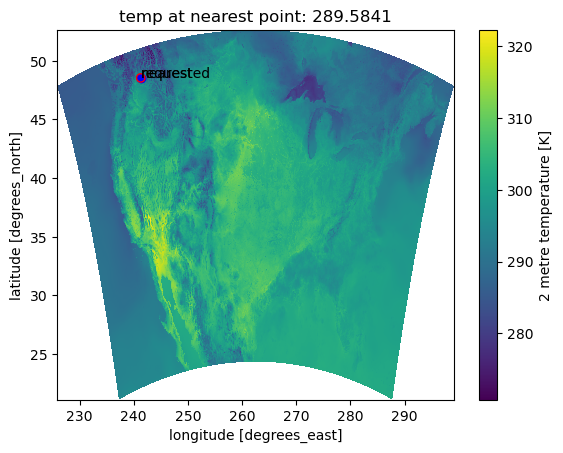

In [11]:
# Code modified from B. Blaylock https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
ds.t2m.plot(x='longitude', y='latitude')

abslat = np.abs(ds.latitude-lat)
abslon = np.abs(ds.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.sel(x=yloc, y=xloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
g=plt.scatter(point_ds.longitude, point_ds.latitude, color='r')
g.set_facecolor('none')
plt.text(point_ds.longitude, point_ds.latitude, 'nearest')

plt.title('temp at nearest point: %s' % point_ds.t2m.data)

Text(0.5, 1.0, 'temp at nearest point: 287.2716')

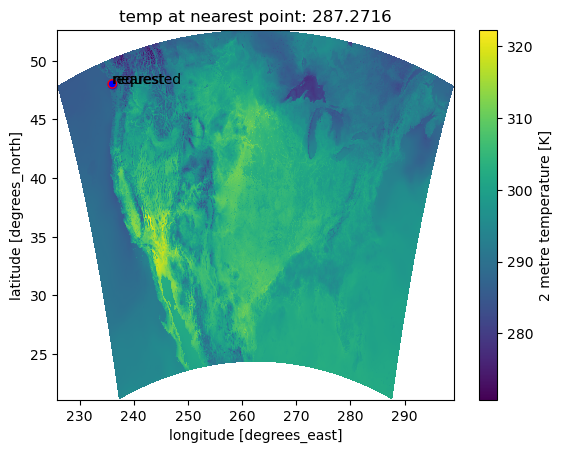

In [12]:
# Desired Lat/Lon pt
# lon = -123.9583 # longitude in deg. W
# lat= 48.02234
lon = points[25][0]
lat = points[25][1]
# Convert to degrees east if HRRR formatted that way
if ds.longitude.attrs['units']=="degrees_east":
    lon = 360 + lon
    # print(lon)
    
# Code modified from B. Blaylock https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
ds.t2m.plot(x='longitude', y='latitude')

abslat = np.abs(ds.latitude-lat)
abslon = np.abs(ds.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.sel(x=yloc, y=xloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
g=plt.scatter(point_ds.longitude, point_ds.latitude, color='r')
g.set_facecolor('none')
plt.text(point_ds.longitude, point_ds.latitude, 'nearest')

plt.title('temp at nearest point: %s' % point_ds.t2m.data)

---
Extract vars at one time slice.

In [22]:
def west_to_east(pts):
    # Convert longitude in list of tuples 
    # from deg W to deg E
    # pts: list of tuples of form (lon, lat)

    ## Extract list of lons and lats
    lons = list(map(lambda pt: pt[0], pts))
    lat = list(map(lambda pt: pt[1], pts))
    ## Convert deg west to deg east
    lons = list(map(lambda l: l+360,lons))
    
    ## Combine back into list of tuples
    coords = [(lons[i], lats[i]) for i in range(0, len(lons))]
    
    return coords

def extract_2m_vars(ds, coord):
    ## Get variables from the 2m above ground HRRR layer
    ## Vars include: temp (k), RH
    # ds: xarray object from HRRR
    # coord: tuple of the form (lon, lat)
    lon = coord[0]
    if ds.longitude.attrs['units']=="degrees_east":
        lon = 360 + lon
        print('Converting target longitude to Deg. E')
    
    lat = coord[1]
    
    abslat = np.abs(ds.latitude-lat)
    abslon = np.abs(ds.longitude-lon)
    c = np.maximum(abslon, abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    # use that index location to get the values, 
    # NOTE: HRRR requires reorder (y,x)
    point_ds = ds.sel(x=yloc, y=xloc)
    
    return point_ds

In [24]:
extract_2m_vars(ds, points[0])

Converting target longitude to Deg. E


<xarray.Dataset>
Dimensions:            ()
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           float64 48.54
    longitude          float64 241.3
    valid_time         datetime64[ns] ...
Data variables:
    unknown            float32 ...
    t2m                float32 ...
    pt                 float32 ...
    sh2                float32 ...
    d2m                float32 ...
    r2                 float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-25T22:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [25]:
extract_2m_vars(ds, points[25])

Converting target longitude to Deg. E


<xarray.Dataset>
Dimensions:            ()
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           float64 48.03
    longitude          float64 236.0
    valid_time         datetime64[ns] ...
Data variables:
    unknown            float32 ...
    t2m                float32 ...
    pt                 float32 ...
    sh2                float32 ...
    d2m                float32 ...
    r2                 float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-25T22:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# os.remove(tempfile)

---
---

Get time range by looping through dates and: 

* temporarily downloading grib file at that date
* extract coords from temp file to build time series
* delete tempfile before iterating

In [ ]:
end_time = "2022-06-01 05:00"
fmt = "%Y-%m-%d %H:%M"
time1 = datetime.strptime(start_time, fmt)
time2 = datetime.strptime(end_time, fmt)
dates = pd.date_range(start=time1,end=time2, freq="1H") # Series of dates

In [ ]:
# Initialize matrix of time series obs
# (x, y, z) dims == (ntime, ncoords, nvars)
vars=["rh", "temp", "solar1", "solar2"]
nvars=len(vars)
obs_mat=np.zeros((dates.shape[0],len(points), nvars), np.float64)

In [ ]:
for d in dates:
    time=d.strftime("%Y-%m-%d %H:%M")
    # print(time)
    
    tempfile = download_grib(
        source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.",
        time = time,
        model = "t18z.wrfsubhf",
        dest_dir =  "data" # destination subdirectory for url content
    )
    
    

    ### manipulate tempfile

    os.remove(tempfile)

In [ ]:

time = dates[1].strftime("%Y-%m-%d %H:%M")
    
tempfile = download_grib(
    source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.",
    time = time,
    model = "t18z.wrfsubhf",
    dest_dir =  "data" # destination subdirectory for url content
)

# manipulate tempfile

os.remove(tempfile)

In [ ]:
# gather_hrrr_time_range(
#     start=start_time,
#     end=end_time
# )